# （4）对多分类任务实验中实现早停机制，并在测试集上测试

+ 选择上述实验中效果最好的组合，手动将训练数据划分为训练集和验证集，实现早停机制，并在测试集上进行测试。训练集：验证集=8：2，早停轮数为5.

根据前面三个实验结果可得:
+ torch.nn L2正则化lambda = 0.001
+ torch.nn dropout = 0.2
+ 使用Adam优化器
上面三个参数所得到的效果分别最好,因此将他们组合

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [ ]:
# 数据预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

# 手动划分训练集和验证集
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

In [ ]:
# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch [1/20], Train Loss: 0.4758, Train Acc: 85.42%, Val Loss: 0.2504, Val Acc: 92.41%
Epoch [2/20], Train Loss: 0.2439, Train Acc: 92.58%, Val Loss: 0.1829, Val Acc: 94.44%
Epoch [3/20], Train Loss: 0.1971, Train Acc: 94.04%, Val Loss: 0.1807, Val Acc: 94.31%
Epoch [4/20], Train Loss: 0.1809, Train Acc: 94.45%, Val Loss: 0.1710, Val Acc: 94.93%
Epoch [5/20], Train Loss: 0.1661, Train Acc: 94.80%, Val Loss: 0.1365, Val Acc: 95.81%
Epoch [6/20], Train Loss: 0.1551, Train Acc: 95.11%, Val Loss: 0.1324, Val Acc: 96.09%
Epoch [7/20], Train Loss: 0.1516, Train Acc: 95.23%, Val Loss: 0.1512, Val Acc: 95.42%
Epoch [8/20], Train Loss: 0.1443, Train Acc: 95.45%, Val Loss: 0.1420, Val Acc: 95.91%
Epoch [9/20], Train Loss: 0.1472, Train Acc: 95.32%, Val Loss: 0.1832, Val Acc: 94.59%
Epoch [10/20], Train Loss: 0.1402, Train Acc: 95.47%, Val Loss: 0.1375, Val Acc: 95.92%
Epoch [11/20], Train Loss: 0.1327, Train Acc: 95.78%, Val Loss: 0.1206, Val Acc: 96.47%
Epoch [12/20], Train Loss: 0.1324, Train 

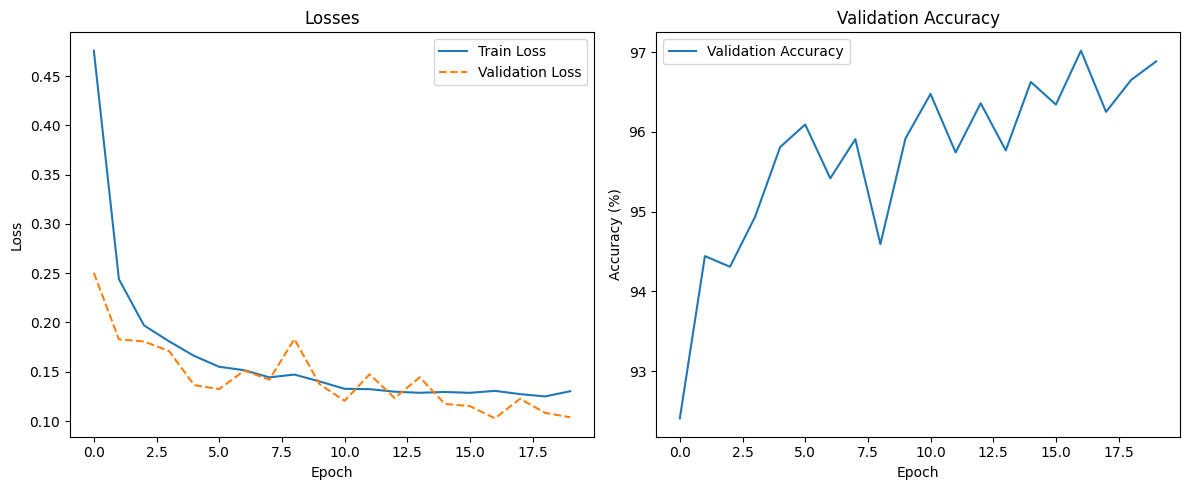

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# 数据预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

# 手动划分训练集和验证集
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 创建模型和损失函数
model = SimpleNN(dropout_rate=0.2)
criterion = nn.CrossEntropyLoss()

# 使用Adam优化器，包含L2正则化（weight_decay）
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# 训练和验证函数
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=20, patience=5):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # 提早停止机制
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # 打印当前 epoch 的训练和验证信息
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # 最后评估测试集
    test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies, test_loss, test_accuracy

# 评估模型在测试集上的表现
def evaluate_model(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return avg_test_loss, test_accuracy


# 训练并评估模型
train_losses, val_losses, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
    model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=20, patience=5)

# 可视化训练和验证损失
plt.figure(figsize=(12, 5))

# Train & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()